# Seasonal preferences - Research 2 and 3
Understanding seasonal trends and using this information to generate better recommendations

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from lightgbm.sklearn import LGBMRanker
from experiment_template import *
from datetime import datetime
import os as os

In [2]:
path = "../Data/"
testing = False
print(os.getcwd())
transactions_train = pd.read_parquet(path + 'transactions_train.parquet')
customers = pd.read_parquet(path + 'customers.parquet')
articles = pd.read_parquet(path + 'articles.parquet')
sample_submission = pd.read_csv(path + 'sample_submission.csv')

C:\Users\Arno\Documents\GitHub\ai-project-23-24\ArnoDeKeersmaeker\Research


In [3]:
transactions_train.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week
25784,2018-09-20,1728846800780188,519773001,0.028458,2,0
25785,2018-09-20,1728846800780188,578472001,0.032525,2,0
5389,2018-09-20,2076973761519164,661795002,0.167797,2,0
5390,2018-09-20,2076973761519164,684080003,0.101678,2,0
47429,2018-09-20,2918879973994241,662980001,0.033881,1,0


## Grouping transactions into seasons ##
Seasons can be defined below. The current season is the season that is used for comparing trends with the other seasons.

In [4]:
# # Define periods here
# seasons = {
#     "Summer": [6,7,8],
#     "Autumn": [9,10,11],
#     "Winter": [12,1,2],
#     "Spring": [3,4,5]
# }
# # Define the name of the current period (end of September)
# current_season = "Autumn"
# 
# ##### SANITY CHECKS #####
# assert current_season in seasons.keys() # Current period exists
# assert set(month_nr for month_nrs in seasons.values() for month_nr in month_nrs) == set(range(1,13)) # Valid month numbers
# assert len([month_nr for month_nrs in seasons.values() for month_nr in month_nrs]) == 12 # Exactly 12 months
# #########################
# 
# inverted = {month_nr: period for period, month_nrs in seasons.items() for month_nr in month_nrs} # For more efficient lookup
# 
# def get_season(month_nr):
#     assert month_nr in range(1,13) # dataset check
#     return inverted[month_nr]
# 
# transactions_train["t_dat"] = pd.to_datetime(transactions_train["t_dat"])
# transactions_train["season"] = transactions_train["t_dat"].dt.month.apply(get_season) # month number to season name

In [5]:
seasons = { # define using week numbers
    "Summer": list(range(22, 35)),
    "Autumn": list(range(35, 45)),
    "Winter": list(range(45, 54)) + list(range(1, 9)),
    "Spring": list(range(9, 22))
}
# Define the name of the current period (end of September)
current_season = "Autumn"

##### SANITY CHECKS #####
assert current_season in seasons.keys() # Current period exists
assert set(week_nr for week_nrs in seasons.values() for week_nr in week_nrs) == set(range(1,54)) # Valid month numbers
assert len([week_nr for week_nrs in seasons.values() for week_nr in week_nrs]) == 53 # Exactly 52 weeks
#########################

inverted = {week_nr: period for period, week_nrs in seasons.items() for week_nr in week_nrs} # For more efficient lookup
lookup = {}

days_in_month = [31,28,31,30,31,30,31,31,30,31,30,31]
def get_season(t_dat):
    if (t_dat.month, t_dat.day) in lookup: # cache
        return lookup[(t_dat.month, t_dat.day)]
    
    day_nr = sum(days_in_month[:t_dat.month-1]) + t_dat.day 
    week_nr = ((day_nr-1) // 7) + 1 
    season = inverted[week_nr] # week number to season name
    lookup[(t_dat.month, t_dat.day)] = season # save to cache
    return season

transactions_train["t_dat"] = pd.to_datetime(transactions_train["t_dat"]) 
transactions_train["season"] = transactions_train["t_dat"].apply(get_season) # month number to season name

In [6]:
# Quickly check the season assignment here
transactions_train[['t_dat', 'season']].sort_values(by='t_dat', ascending=True).drop_duplicates().reset_index()

,index,t_dat,season
0,25784,2018-09-20,Autumn
1,66713,2018-09-21,Autumn
2,98452,2018-09-22,Autumn
3,155449,2018-09-23,Autumn
4,186101,2018-09-24,Autumn
...,...,...,...
729,31645833,2020-09-18,Autumn
730,31678015,2020-09-19,Autumn
731,31700441,2020-09-20,Autumn
732,31738026,2020-09-21,Autumn


In [7]:
print(len(transactions_train))

31788324


## Grouping customers into segments ##
Trends are different for people in different segments (age group etc). Therefore, we need group customers into segments.
Segments will have entirely separated score calculations.

In [8]:
# Prepare the customers dataframe for segmentation

average_age = int(customers[customers['age'] != -1]['age'].mean()) # do not include -1 for average age
customers['age'] = customers['age'].replace(-1, int(average_age))


##### SANITY CHECKS #####
assert all(customers['age'] != -1) # no more -1 values
assert not customers["age"].hasnans
#########################

customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code
0,6883939031699146327,-1,-1,0,0,49,6305
1,11246327431398957306,-1,-1,0,0,25,33726
2,18439897732908966680,-1,-1,0,0,24,3247
3,18352672461570950206,-1,-1,0,0,54,168643
4,18162778555210377306,1,1,0,1,52,168645
...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351
1371976,9305341941720086711,-1,-1,0,0,21,80169
1371977,10160427316885688932,1,1,0,1,21,106737
1371978,2551401172826382186,1,1,0,1,18,111894


In [9]:
# segment definition   column_name -> dict {column_value -> segment_name}
segments = {
    # "age" : {float(age): "young" if age < 35 else "middle-old" for age in range(0,120)},
    # "FN" : {1.0 : "yes_FN", -1.0: "no_FN"},
    "age" : {float(age): "age_young" for age in range(0,120)}
}

segmented_customers = customers.copy()
segment_names = set()

def assign_segment(row):
    # Decide the segment for a single customer
    segment_name = [segments[column][row[column]] for column in segments] # find label for each column
    segment_name = "/".join(segment_name) # composite segment name eg "age_young/yes_FN"
    segment_names.add(segment_name)
    return segment_name

# Apply to every customer
segmented_customers['segment'] = segmented_customers.apply(assign_segment, axis=1)

segment_names = list(segment_names)
print(f"Customer segments: {segment_names}")

##### SANITY CHECKS #####
for column in segments.keys(): assert column in customers.columns # columns that determine segments need to exist
assert len(segmented_customers) == len(customers) # divides all customers into segments
assert all(segment_name not in customers.columns for segment_name in segment_names) # segment names will be added as columns so need to be new
assert all(segment_name not in articles.columns for segment_name in segment_names)
assert all(segment_name not in transactions_train.columns for segment_name in segment_names)
#########################

segmented_customers

Customer segments: ['age_young']


,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,segment
0,6883939031699146327,-1,-1,0,0,49,6305,age_young
1,11246327431398957306,-1,-1,0,0,25,33726,age_young
2,18439897732908966680,-1,-1,0,0,24,3247,age_young
3,18352672461570950206,-1,-1,0,0,54,168643,age_young
4,18162778555210377306,1,1,0,1,52,168645,age_young
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,age_young
1371976,9305341941720086711,-1,-1,0,0,21,80169,age_young
1371977,10160427316885688932,1,1,0,1,21,106737,age_young
1371978,2551401172826382186,1,1,0,1,18,111894,age_young


In [10]:
# Other attributes become irrelevant after determining the segment
segmented_customers = segmented_customers[['customer_id', 'segment']]

# Add segment to transactions, so we can split them up later
transactions = pd.merge(transactions_train, segmented_customers, on="customer_id") # add segment to customers
assert len(transactions) == len(transactions_train)

In [11]:
# split the transactions: segment_name -> transactions
transactions_per_segment = {}


for segment_name in segment_names:
    transactions_per_segment[segment_name] = transactions[transactions['segment'] == segment_name]

## Initial visualizations ##
To check whether the segments and seasons make sense

In [12]:
def pie_plot(data_column, title):
    counts = data_column.value_counts()
    assert counts.sum() == len(data_column)
    
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%')
    plt.axis('equal')
    plt.title(title)
    plt.show()

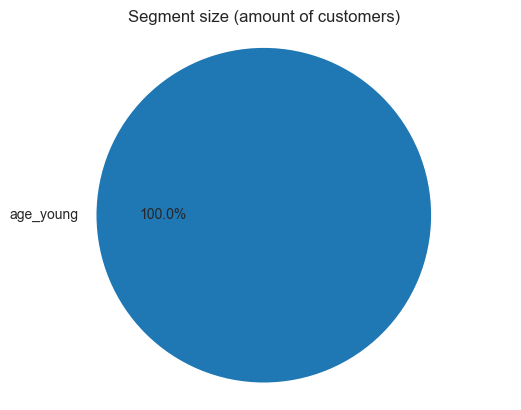

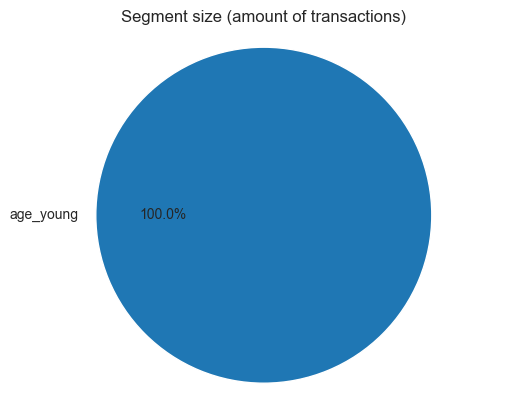

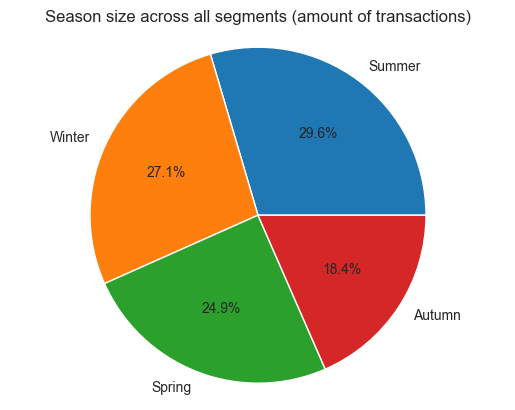

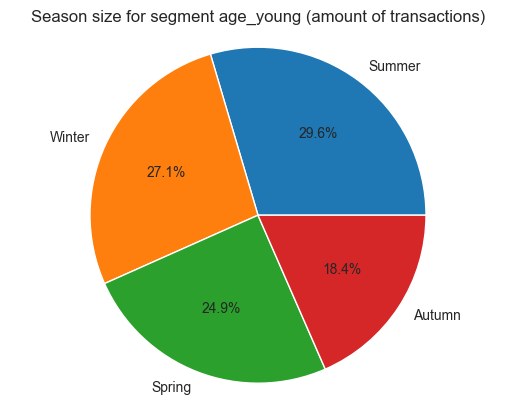

In [13]:
#Visualize segment sizes
pie_plot(segmented_customers['segment'], "Segment size (amount of customers)")
pie_plot(transactions['segment'], "Segment size (amount of transactions)")
pie_plot(transactions['season'], "Season size across all segments (amount of transactions)")
for segment_name in segment_names:
    pie_plot(transactions_per_segment[segment_name]['season'], f"Season size for segment {segment_name} (amount of transactions)")

## Calculating feature scores ##
Use increases or decreases in sales of articles with a specific feature (eg. color=blue) of a season compared to all seasons to calculate a score for that feature.

In [14]:
# Each segment has an entry in the transactions_per_segment dictionary
next(iter(transactions_per_segment.values()))

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment
0,2018-09-20,1728846800780188,519773001,0.028458,2,0,Autumn,age_young
1,2018-09-20,1728846800780188,578472001,0.032525,2,0,Autumn,age_young
2,2018-10-05,1728846800780188,533518001,0.047441,2,2,Autumn,age_young
3,2018-10-05,1728846800780188,569981006,0.020322,2,2,Autumn,age_young
4,2018-10-05,1728846800780188,669393001,0.067797,2,2,Autumn,age_young
...,...,...,...,...,...,...,...,...
31788319,2020-09-22,18409112236320621348,621381014,0.033881,2,104,Autumn,age_young
31788320,2020-09-22,18417769707947924979,729860001,0.022017,2,104,Autumn,age_young
31788321,2020-09-22,18417769707947924979,889747001,0.022017,2,104,Autumn,age_young
31788322,2020-09-22,18417769707947924979,778517001,0.022017,2,104,Autumn,age_young


In [15]:
# (segment_name, feature_name) -> {feature_value -> score}
# eg: for people under 35, the score of a blue article is 1.2
all_scores = {} 

# features to use for calculating seasonal score
features = ["product_type_name", "product_group_name", "graphical_appearance_name", "colour_group_name", "perceived_colour_value_name", "perceived_colour_master_name", "department_name", "index_name", "index_group_name", "section_name", "garment_group_name"]

In [16]:
# # As seen in the visualizations above, the amount of transactions differs per season
# # Therefore, we can't just absolutely count the amount of transactions per feature
# 
# 
# # for each segment, find the relative size of the current season compared to all seasons
# relative_size_per_segment = {}
# 
# # calculated fully separated based on segment
# for segment_name, segment in transactions_per_segment.items():
#     current_period_size = len(segment[segment['season'] == current_season]) # amount of transactions in current season
#     all_periods_size = len(segment) # amount of transactions in all seasons
#     relative_size_per_segment[segment_name] = current_period_size / all_periods_size
# 
# relative_size_per_segment


# # for each segment, calculate all scores separately
# for segment_name, segment_transactions in transactions_per_segment.items():
#     print(f"Current segment: {segment_name}")
#     segment_transactions = pd.merge(segment_transactions, articles, on="article_id")
# 
#     # find the ratio for each feature
#     for feature in features:
#         seasonal_sales_by_type = segment_transactions.groupby(["season", feature])["article_id"].size().reset_index(name="count")
#         assert seasonal_sales_by_type["count"].sum() == len(segment_transactions)
#         relative_season_size = 1 / relative_size_per_segment[segment_name] # relative size of the current season compared to all seasons
# 
#         # Calculate the average sales over all seasons for each feature type (eg average sales of an article that's blue)
#         type_average_sales = seasonal_sales_by_type.groupby([feature])["count"].sum().div(relative_season_size).reset_index(name = "avg_all_seasons")
# 
#         # Only current season is relevant from now on
#         seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["season"] == current_season]
#         seasonal_sales_by_type = seasonal_sales_by_type.merge(type_average_sales, on=feature)
#         seasonal_sales_by_type["season_ratio"] = seasonal_sales_by_type["count"] / seasonal_sales_by_type["avg_all_seasons"]
# 
#         # # Only keeping the 75% most sold combinations
#         # threshold = seasonal_sales_by_type["count"].quantile(0.25)
#         # seasonal_sales_by_type = seasonal_sales_by_type[seasonal_sales_by_type["count"] > threshold]
# 
#         # Creating a ratio look up table
#         seasonal_sales_by_type = seasonal_sales_by_type[[feature, "season_ratio"]]
#         seasonal_sales_by_type = seasonal_sales_by_type.rename(columns = {feature: "feature"})
# 
#         # Save together with the other segments
#         all_scores[(segment_name, feature)] = seasonal_sales_by_type.set_index("feature").to_dict()["season_ratio"]
# print("Done")

In [17]:
# Less confusing implementation with the same result
# For each feature and each segment
# STEP 1. Calculating the ratio of purchases of a feature (eg. color blue) in the current season
# STEP 2. Calculating the ratio of purchases of a feature (eg. color blue) in all seasons
# STEP 3. Taking the ratio of the two ratios -> how much more popular is the feature in the current season compared to all seasons

# for each segment, calculate all scores separately
for segment_name, segment_transactions in transactions_per_segment.items():
    print(f"Current segment: {segment_name}")
    segment_transactions = pd.merge(segment_transactions, articles, on="article_id")
    current_season_transactions = segment_transactions[segment_transactions["season"] == current_season] # only relevant season

    # find the ratio for each feature
    for feature in features:
        # STEP 1
        # For each possible value of the feature, check how many times it was sold in the current season
        current_season_ratio = current_season_transactions.groupby([feature])["article_id"].size().reset_index(name="count")
        
        # Then calculate the ratio of that feature value compared to all purchases in the current season
        current_season_ratio["current_season_ratio"] = current_season_ratio["count"] / current_season_ratio["count"].sum()
        current_season_ratio = current_season_ratio[[feature, "current_season_ratio"]] # keep relevant columns
        
        
        # STEP 2
        # Same as step 1, but for all seasons
        all_seasons_ratio = segment_transactions
        all_seasons_ratio = all_seasons_ratio.groupby([feature])["article_id"].size().reset_index(name="count")
        all_seasons_ratio["all_seasons_ratio"] = all_seasons_ratio["count"] / all_seasons_ratio["count"].sum()
        all_seasons_ratio = all_seasons_ratio[[feature, "all_seasons_ratio"]]
        
        # STEP 3
        # Merge the two tables and calculate the ratio of the two ratios
        score = pd.merge(current_season_ratio, all_seasons_ratio, on=feature) 
        score["season_ratio"] = score["current_season_ratio"] / score["all_seasons_ratio"]
        score = score[[feature, "season_ratio"]]
        score = score.rename(columns = {feature: "feature"})


        ##### SANITY CHECKS #####
        assert len(score) == len(current_season_transactions[feature].unique()) # every feature value that occurs in the current season gets a score
        assert score["season_ratio"].min() >= 0
        #########################
        

        # Save together with the other segments
        all_scores[(segment_name, feature)] = score.set_index("feature").to_dict()["season_ratio"]
# print("Done")

Current segment: age_young


In [18]:
# all_scores[("age_young", "colour_group_name")]

## Calculating article scores ##
Use the feature scores to calculate a score for each article.

In [19]:
# Calculate the season compatibility scores for each article
# The score of an article is the sum of the scores of its features

def create_article_scores(article):
    result = [0 for _ in range(len(segment_names))] # all counters start at 0
    
    # feature by feature, segment by segment
    for feature in features:
        feature_value = article[feature] # the feature value of the article (e.g. color blue)
        for i, segment_name in enumerate(segment_names):
            score_table = all_scores[(segment_name, feature)] # table that gives the feature score of a segment
            if not feature_value in score_table:
                continue
            result[i] += score_table[feature_value] # sum (better than multiplication)
            
    ##### SANITY CHECKS #####
    assert len(result) == len(segment_names) # one score for each segment
    assert all(res >= 0 for res in result)
    #########################
    
    return pd.Series(result)

In [20]:
articles_scores = pd.DataFrame(articles["article_id"]) # create a dataframe with only the article id

# Create a column for each segment, containing the score of the article for that segment
articles_scores[segment_names] = articles.apply(create_article_scores, axis=1, result_type="expand")

# Normalize the scores for each segment
for segment_name in segment_names:
    articles_scores[segment_name] = MinMaxScaler().fit_transform(articles_scores[[segment_name]])

##### SANITY CHECKS #####
assert len(articles_scores) == len(articles)
assert all(0 <= score <= 1 for score in articles_scores[segment_names].values.flatten()) # scores are normalized
#########################

articles_scores.head()

,article_id,age_young
0,108775015,0.356218
1,108775044,0.289761
2,108775051,0.297623
3,110065001,0.294080
4,110065002,0.227623


In [21]:
articles_scores.to_parquet(path + 'articles_edited2.parquet')

## Calculating applicable scores ##
Find the right score for each transaction, depending on the segment of the customer.

In [22]:
applicable_scores = transactions_train[["customer_id", "article_id", "season"]]
length = len(applicable_scores)
applicable_scores = pd.merge(applicable_scores, articles_scores, on="article_id", how="left")
applicable_scores = pd.merge(applicable_scores, segmented_customers, on="customer_id", how="left")

assert len(applicable_scores) == length
assert all(segment_name in applicable_scores.columns for segment_name in segment_names) # segment columns are needed

idx, cols = pd.factorize(applicable_scores['segment'])
result = applicable_scores.reindex(cols, axis=1).to_numpy()[np.arange(len(applicable_scores)), idx]

##### SANITY CHECKS #####
assert len(result) == len(applicable_scores)
if testing: # takes more time so only enable for testing

    # For testing purposes: less efficient but more clear implementation should have the same result
    def get_applicable_score(row):
        return row[row["segment"]] # Take the value of the corresponding segment column

    test_result = applicable_scores.apply(get_applicable_score, axis=1).values
    assert np.array_equal(result, test_result)
#########################

applicable_scores["transaction_score"] = result
applicable_scores.head()

,customer_id,article_id,season,age_young,segment,transaction_score
0,1728846800780188,519773001,Autumn,0.613575,age_young,0.613575
1,1728846800780188,578472001,Autumn,0.531785,age_young,0.531785
2,2076973761519164,661795002,Autumn,0.541438,age_young,0.541438
3,2076973761519164,684080003,Autumn,0.555221,age_young,0.555221
4,2918879973994241,662980001,Autumn,0.617765,age_young,0.617765


In [23]:
applicable_scores.drop(columns=segment_names + ["segment"], inplace=True)
applicable_scores.head()

,customer_id,article_id,season,transaction_score
0,1728846800780188,519773001,Autumn,0.613575
1,1728846800780188,578472001,Autumn,0.531785
2,2076973761519164,661795002,Autumn,0.541438
3,2076973761519164,684080003,Autumn,0.555221
4,2918879973994241,662980001,Autumn,0.617765


## Customer sensitivity ##
Use historical transactions of customers to calculate how sensitive they are to the trends of the current season.

In [24]:
# Per customer, calculate the average score of the articles they bought
customer_sensitivity = applicable_scores[applicable_scores["season"] == current_season]
customer_sensitivity = customer_sensitivity.groupby(["customer_id"])["transaction_score"].mean().reset_index()
customer_sensitivity = customer_sensitivity.rename(columns={"transaction_score": "sensitivity"})

##### SANITY CHECKS #####
assert all(0 <= score <= 1 for score in customer_sensitivity["sensitivity"])
#########################

customer_sensitivity

,customer_id,sensitivity
0,28847241659200,0.413612
1,41318098387474,0.477254
2,43757848922470,0.360714
3,77117344919861,0.461077
4,116809474287335,0.460490
...,...,...
698853,18446590778427270109,0.415508
698854,18446624797007271432,0.462242
698855,18446630855572834764,0.446667
698856,18446705133201055310,0.562922


In [25]:
# Add new feature to customers table
customers = pd.merge(customers, customer_sensitivity, on="customer_id", how="left")
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,sensitivity
0,6883939031699146327,-1,-1,0,0,49,6305,0.433895
1,11246327431398957306,-1,-1,0,0,25,33726,0.436180
2,18439897732908966680,-1,-1,0,0,24,3247,0.344426
3,18352672461570950206,-1,-1,0,0,54,168643,NaN
4,18162778555210377306,1,1,0,1,52,168645,0.503895
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,0.358548
1371976,9305341941720086711,-1,-1,0,0,21,80169,0.371118
1371977,10160427316885688932,1,1,0,1,21,106737,0.429525
1371978,2551401172826382186,1,1,0,1,18,111894,NaN


In [26]:
# Customers who didn't buy anything in the current season have no data
# Fill their sensitivity with the average sensitivity

average = customers["sensitivity"].mean()
customers["sensitivity"].fillna(average, inplace=True)

# normalize
customers["sensitivity"] = MinMaxScaler().fit_transform(customers[["sensitivity"]])
customers

,customer_id,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,sensitivity
0,6883939031699146327,-1,-1,0,0,49,6305,0.576074
1,11246327431398957306,-1,-1,0,0,25,33726,0.579112
2,18439897732908966680,-1,-1,0,0,24,3247,0.457142
3,18352672461570950206,-1,-1,0,0,54,168643,0.547179
4,18162778555210377306,1,1,0,1,52,168645,0.669126
...,...,...,...,...,...,...,...,...
1371975,7551062398649767985,-1,-1,0,0,24,50351,0.475915
1371976,9305341941720086711,-1,-1,0,0,21,80169,0.492624
1371977,10160427316885688932,1,1,0,1,21,106737,0.570265
1371978,2551401172826382186,1,1,0,1,18,111894,0.547179


In [27]:
# For each customer calculate the standard deviation of the prices of the transactions
price_sensitivity = transactions_train.groupby('customer_id')['price'].std().reset_index()
price_sensitivity.rename(columns={'price': 'price_sensitivity'}, inplace=True)

# When a customer has only one transaction, there is no standard deviation, so fill with 0
price_sensitivity['price_sensitivity'].fillna(0, inplace=True)

customers = pd.merge(customers, price_sensitivity, on='customer_id', how='left')

# Customers with no transactions should get value 0
customers['price_sensitivity'].fillna(0, inplace=True)

## Prepare for training ##
Below is an adapted version of Noah's template version of Radek's code.

In [28]:
columns_to_use = [
    'article_id',
    'product_type_no',
    'graphical_appearance_no',
    'colour_group_code',
    'perceived_colour_value_id',
    'perceived_colour_master_id',
    'department_no',
    'index_code',
    'index_group_no',
    'section_no',
    'garment_group_no',
    'FN',
    'Active',
    'club_member_status',
    'fashion_news_frequency',
    'age',
    'postal_code',
    'ranked_weighted_sales',
    "price_sensitivity",
]
def add_features(data):
    result = data
    result = pd.merge(result, customers, how='left', on='customer_id')
    result = pd.merge(result, articles, how='left', on='article_id')

    # features from assignment 2 could go here
    # customer_avg_price = transactions_train.groupby('customer_id')['price'].mean().to_frame('preferred_price')
    # result = pd.merge(result, customer_avg_price, how="left", on="customer_id")

    return result[columns_to_use]

In [29]:
def recall(predictions, purchases, k=12):
    # number of correct predictions for the customer / items bought by the customer
    # total recall is the average recall over all customers

    def row_recall(row):
        assert 0 < len(row.purchases)
        correct = 0
        for predicted_item in row.prediction[:k]:
            if predicted_item in row.purchases:
                correct += 1
        return correct / min(len(row.purchases), 12)

    result = pd.merge(purchases, predictions, on="customer_id", how="inner")
    result["recall"] = result.apply(row_recall, axis=1)

    return result.recall.sum() / len(purchases)

In [30]:
segmented_customers

,customer_id,segment
0,6883939031699146327,age_young
1,11246327431398957306,age_young
2,18439897732908966680,age_young
3,18352672461570950206,age_young
4,18162778555210377306,age_young
...,...,...
1371975,7551062398649767985,age_young
1371976,9305341941720086711,age_young
1371977,10160427316885688932,age_young
1371978,2551401172826382186,age_young


In [49]:
### split into training and testing
# one week is used for testing
# a number of weeks leading up to the test week are used to train the ranker
test_week = 105
num_training_weeks = 8
training_weeks = np.arange(test_week-num_training_weeks, test_week)
train_data = transactions_train[transactions_train.week.isin(training_weeks)].reset_index(drop=True)

# add segment of the customer to each transaction
train_data = train_data.merge(segmented_customers, on="customer_id")
train_data.head()

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment
0,2020-07-29,1152192358796555,720125042,0.018627,1,97,Summer,age_young
1,2020-07-29,1152192358796555,160442010,0.013542,1,97,Summer,age_young
2,2020-08-11,1152192358796555,786304001,0.025407,1,98,Summer,age_young
3,2020-07-29,2059722054851309,862821001,0.016932,2,97,Summer,age_young
4,2020-07-29,2059722054851309,932365006,0.033881,2,97,Summer,age_young


In [50]:
articles_scores.head()

,article_id,age_young
0,108775015,0.356218
1,108775044,0.289761
2,108775051,0.297623
3,110065001,0.294080
4,110065002,0.227623


In [51]:
### repurchase
# each week is seen as a basket
# the items bought in one basket, will be example for the next basket
# the items bought in the last basket, will be candidates for the test basket
c2weeks = train_data.groupby('customer_id')['week'].unique()
c2weeks2shifted_weeks = {}
for c_id, weeks in c2weeks.items():
    c2weeks2shifted_weeks[c_id] = {}
    for i in range(weeks.shape[0]-1):
        c2weeks2shifted_weeks[c_id][weeks[i]] = weeks[i+1]
    c2weeks2shifted_weeks[c_id][weeks[-1]] = test_week
candidates_last_purchase = train_data.copy()
weeks = []
for i, (c_id, week) in enumerate(zip(train_data['customer_id'], train_data['week'])):
    weeks.append(c2weeks2shifted_weeks[c_id][week])
candidates_last_purchase.week=weeks

sales_counts = train_data.groupby(["week", "article_id", "segment"]).size().reset_index(name="count")
sales_counts = sales_counts.merge(articles_scores, on="article_id")
sales_counts

,week,article_id,segment,count,age_young
0,97,108775044,age_young,6,0.289761
1,98,108775044,age_young,5,0.289761
2,99,108775044,age_young,5,0.289761
3,100,108775044,age_young,1,0.289761
4,101,108775044,age_young,8,0.289761
...,...,...,...,...,...
155118,104,944241001,age_young,35,0.406491
155119,104,945600001,age_young,12,0.499554
155120,104,946475001,age_young,1,0.367061
155121,104,946527001,age_young,4,0.316251


In [52]:
def get_applicable_score(row):
    return row[row["segment"]]
sales_counts = sales_counts.copy()
sales_counts["season_score"] = sales_counts.apply(get_applicable_score, axis=1)
sales_counts

,week,article_id,segment,count,age_young,season_score
0,97,108775044,age_young,6,0.289761,0.289761
1,98,108775044,age_young,5,0.289761,0.289761
2,99,108775044,age_young,5,0.289761,0.289761
3,100,108775044,age_young,1,0.289761,0.289761
4,101,108775044,age_young,8,0.289761,0.289761
...,...,...,...,...,...,...
155118,104,944241001,age_young,35,0.406491,0.406491
155119,104,945600001,age_young,12,0.499554,0.499554
155120,104,946475001,age_young,1,0.367061,0.367061
155121,104,946527001,age_young,4,0.316251,0.316251


In [53]:
sales_counts = sales_counts.drop(columns=segment_names)
sales_counts

,week,article_id,segment,count,season_score
0,97,108775044,age_young,6,0.289761
1,98,108775044,age_young,5,0.289761
2,99,108775044,age_young,5,0.289761
3,100,108775044,age_young,1,0.289761
4,101,108775044,age_young,8,0.289761
...,...,...,...,...,...
155118,104,944241001,age_young,35,0.406491
155119,104,945600001,age_young,12,0.499554
155120,104,946475001,age_young,1,0.367061
155121,104,946527001,age_young,4,0.316251


In [54]:
sales_counts["weighted_sales"] = sales_counts["count"] ** sales_counts["season_score"]
sales_counts

,week,article_id,segment,count,season_score,weighted_sales
0,97,108775044,age_young,6,0.289761,1.680652
1,98,108775044,age_young,5,0.289761,1.594168
2,99,108775044,age_young,5,0.289761,1.594168
3,100,108775044,age_young,1,0.289761,1.000000
4,101,108775044,age_young,8,0.289761,1.826754
...,...,...,...,...,...,...
155118,104,944241001,age_young,35,0.406491,4.242773
155119,104,945600001,age_young,12,0.499554,3.460265
155120,104,946475001,age_young,1,0.367061,1.000000
155121,104,946527001,age_young,4,0.316251,1.550250


In [55]:
sales_counts["ranked_weighted_sales"] = (sales_counts.groupby("week")["weighted_sales"].rank(method="dense", ascending=False).astype("int64"))
sales_counts

,week,article_id,segment,count,season_score,weighted_sales,ranked_weighted_sales
0,97,108775044,age_young,6,0.289761,1.680652,8785
1,98,108775044,age_young,5,0.289761,1.594168,8455
2,99,108775044,age_young,5,0.289761,1.594168,8546
3,100,108775044,age_young,1,0.289761,1.000000,12948
4,101,108775044,age_young,8,0.289761,1.826754,7124
...,...,...,...,...,...,...,...
155118,104,944241001,age_young,35,0.406491,4.242773,1506
155119,104,945600001,age_young,12,0.499554,3.460265,2213
155120,104,946475001,age_young,1,0.367061,1.000000,11249
155121,104,946527001,age_young,4,0.316251,1.550250,7851


In [56]:
sales_counts = sales_counts[sales_counts["ranked_weighted_sales"] <= 12]
sales_counts.week += 1
sales_counts = sales_counts.sort_values(by=["week", "article_id", "segment"])

# A list of all customers that bought something during each week
customers_per_week = (train_data.groupby(['week', 'customer_id', 'segment']).head(1).
                      drop(columns=['article_id', 'price', "t_dat", "season", "sales_channel_id"]).drop_duplicates(["week","customer_id"]).copy())
candidates_bestsellers = pd.merge(customers_per_week,sales_counts,on=['week', 'segment'])
candidates_bestsellers_test_week = customers_per_week.drop_duplicates('customer_id').reset_index(drop=True) # all customers who ever bought something
candidates_bestsellers_test_week.week = test_week # join on test week
candidates_bestsellers_test_week = pd.merge(candidates_bestsellers_test_week,sales_counts,on=['week', 'segment'])
candidates_bestsellers = pd.concat([candidates_bestsellers, candidates_bestsellers_test_week])
candidates_bestsellers.drop(columns='ranked_weighted_sales', inplace=True)

### combine
d = train_data.copy()
d['purchased'] = True

candidates = pd.concat([
    d, candidates_last_purchase, candidates_bestsellers
])

C:\Users\Arno\AppData\Local\Temp\ipykernel_24404\1642060979.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sales_counts.week += 1


In [57]:
candidates

,t_dat,customer_id,article_id,price,sales_channel_id,week,season,segment,purchased,count,season_score,weighted_sales
0,2020-07-29,1152192358796555,720125042,0.018627,1.0,97,Summer,age_young,True,NaN,NaN,NaN
1,2020-07-29,1152192358796555,160442010,0.013542,1.0,97,Summer,age_young,True,NaN,NaN,NaN
2,2020-08-11,1152192358796555,786304001,0.025407,1.0,98,Summer,age_young,True,NaN,NaN,NaN
3,2020-07-29,2059722054851309,862821001,0.016932,2.0,97,Summer,age_young,True,NaN,NaN,NaN
4,2020-07-29,2059722054851309,932365006,0.033881,2.0,97,Summer,age_young,True,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4544251,NaT,18438270306572912089,915529003,NaN,NaN,105,NaN,age_young,NaN,495.0,0.550021,30.345148
4544252,NaT,18438270306572912089,915529005,NaN,NaN,105,NaN,age_young,NaN,491.0,0.561946,32.526820
4544253,NaT,18438270306572912089,918525001,NaN,NaN,105,NaN,age_young,NaN,342.0,0.561946,26.545140
4544254,NaT,18438270306572912089,924243001,NaN,NaN,105,NaN,age_young,NaN,852.0,0.561946,44.335117


In [58]:
candidates.purchased.fillna(False, inplace=True)
candidates.drop_duplicates(['customer_id', 'article_id', 'week'], inplace=True)

candidates = pd.merge(
    candidates,
    sales_counts[['week', 'article_id', 'ranked_weighted_sales']],
    on=['week', 'article_id'],
    how='left'
)
candidates = candidates[candidates.week != candidates.week.min()]
candidates["ranked_weighted_sales"].fillna(999, inplace=True)

candidates.sort_values(['week', 'customer_id'], inplace=True)
candidates.reset_index(drop=True, inplace=True)

train_examples = candidates[candidates.week != test_week]
X_train = add_features(train_examples)
Y_train = train_examples['purchased']

ranker = LGBMRanker(
    force_row_wise=True,
    objective="lambdarank",
    metric="ndcg",
    boosting_type="dart",
    n_estimators=1,
    importance_type='gain',
    verbose=10
)
train_groups = train_examples.groupby(['week', 'customer_id'])['article_id'].count().values

In [59]:
X_train

,article_id,product_type_no,graphical_appearance_no,colour_group_code,perceived_colour_value_id,perceived_colour_master_id,department_no,index_code,index_group_no,section_no,garment_group_no,FN,Active,club_member_status,fashion_news_frequency,age,postal_code,ranked_weighted_sales,price_sensitivity
0,868879003,265,1010001,73,2,2,1310,0,1,6,1013,-1,-1,0,0,75,198314,999.0,0.007418
1,547780003,272,1010010,7,1,12,1643,1,2,51,1002,-1,-1,0,0,75,198314,5.0,0.007418
2,579541001,245,1010016,9,4,5,1616,0,1,11,1003,-1,-1,0,0,75,198314,2.0,0.007418
3,579541075,245,1010010,6,1,12,1616,0,1,11,1003,-1,-1,0,0,75,198314,8.0,0.007418
4,678942001,254,1010016,9,4,5,1616,0,1,11,1003,-1,-1,0,0,75,198314,10.0,0.007418
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8545737,911870003,252,1010010,15,2,1,1626,0,1,15,1003,1,1,0,1,60,96323,5.0,0.011623
8545738,915529003,252,1010016,9,4,5,1626,0,1,15,1003,1,1,0,1,60,96323,11.0,0.011623
8545739,918525001,252,1010016,13,1,1,1626,0,1,15,1003,1,1,0,1,60,96323,10.0,0.011623
8545740,924243001,252,1010016,13,1,1,1626,0,1,15,1003,1,1,0,1,60,96323,2.0,0.011623


In [60]:
ranker.fit(X_train, Y_train, group=train_groups)
print_importance(ranker, X_train.columns)

### test
# candidates are generated similarly to the examples, only we don't know whether they are purchased
# the same features are extracted and added
# each candidate is scored by the ranker and predictions are generated using the highest scoring candidates
test_candidates = candidates[candidates.week == test_week]

X_test = add_features(test_candidates)
predictions = get_predictions(test_candidates, X_test, ranker, 12)

[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.163784
[LightGBM] [Info] Total Bins 1401
[LightGBM] [Info] Number of data points in the train set: 8545742, number of used features: 19
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
         ranked_weighted_sales 0.99845
             price_sensitivity 0.00073
                    article_id 0.00016
               product_type_no 0.00015
                 department_no 0.00015
                           age 0.00011
       graphical_appearance_no 0.00006
              garment_group_no 0.00005
                    section_no 0.00004
     perceived_colour_value_id 0.00004
             colour_group_code 0.00003
                    index_code 0.00002
        fashion_news_frequency 0.00000
            club_member_status 0.00000
                        Active 0.00000
                            FN 0.00000
                   postal_code 0.00000
                index_group_no 0.00000
    perceived_colour_maste

In [61]:
len(predictions)

378688

In [62]:
### evaluate
if test_week < transactions_train.week.max() + 1:
    # get ground truth data for test week
    purchases = get_purchases(transactions_train[transactions_train.week == test_week])

    # fill missing prediction for customers in test set with popular items in last week
    # only for customers in test set because only those are evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, purchases.customer_id, popular)

    # calculate score
    score = mean_average_precision(predictions, purchases, 12)
    print(score)
    score2 = recall(predictions, purchases, 12)
    print(score2)

### submit
else:
    # fill missing predictions for all customers with popular items in last week
    # all customers because we don't know which ones will be evaluated
    popular = transactions_train[transactions_train.week == test_week-1].article_id.value_counts().head(12).index.values
    predictions = fill_missing_predictions(predictions, customers.customer_id, popular)

    # write submission
    sub = create_submission(predictions, sample_submission)
    sub.to_csv(path + 'sub1.csv.gz', index=False)

In [63]:
sales_counts

,week,article_id,segment,count,season_score,weighted_sales,ranked_weighted_sales
6223,98,547780003,age_young,282,0.470601,14.226248,5
9607,98,579541001,age_young,160,0.557260,16.914838,2
9633,98,579541075,age_young,71,0.608558,13.384399,8
17955,98,678942001,age_young,140,0.511805,12.542941,10
18017,98,678942057,age_young,94,0.549270,12.127715,11
...,...,...,...,...,...,...,...
128355,105,915529003,age_young,495,0.550021,30.345148,6
147747,105,915529005,age_young,491,0.561946,32.526820,5
151384,105,918525001,age_young,342,0.561946,26.545140,10
147958,105,924243001,age_young,852,0.561946,44.335117,1


In [64]:
predictions.head()

,customer_id,prediction
0,28847241659200,"[925246001, 915529005, 924243001, 915529003, 9..."
1,41318098387474,"[868879003, 915529005, 924243001, 915529003, 9..."
2,116809474287335,"[906305002, 915529005, 924243001, 915529003, 9..."
3,200292573348128,"[903861001, 915529005, 924243001, 915529003, 9..."
4,272412481300040,"[923460002, 922381001, 921906005, 915529005, 9..."


In [65]:
def catalog_coverage(predictions):
    all_articles = set(articles["article_id"].unique())
    all_recommended = set()
    for index, row in predictions.iterrows():
        all_recommended.update(row["prediction"])
    return len(all_recommended) / len(all_articles)

catalog_coverage(predictions)

0.2994352959011578

In [66]:
def jaccard_similarity(pred1, pred2):
    intersection = len(pred1.intersection(pred2))
    union = len(pred1.union(pred2))
    return intersection / union if union > 0 else 0

sample_predictions = predictions.sample(n=1000)


def diversity(predictions):
    # Calculate Diversity@K
    diversities = []
    for i, row1 in predictions.iterrows():
        set1 = set(row1['prediction'])
        diversity_sum = 0
        num_customers = 0
        for j, row2 in predictions.iterrows():
            if i < j:  # Avoid comparing a customer with themselves
                set2 = set(row2['prediction'])
                diversity_sum += jaccard_similarity(set1, set2)
                num_customers += 1
        average_diversity = diversity_sum / num_customers if num_customers > 0 else 0
        diversities.append(average_diversity)
    return sum(diversities) / len(predictions)


print(diversity(sample_predictions))

0.7596227553660658
